In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from pathlib import Path

# --- 경로 설정 ---
ROOT_DIR = Path.cwd().parent 
DATA_DIR = ROOT_DIR / "BIgcontest_Data"
CROLLING_DIR = ROOT_DIR / "Crolling"
EDA_DIR = ROOT_DIR / "EDA"
MODEL_DIR = ROOT_DIR / "Model"

In [5]:
# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

print("--- 잠재 공간(Latent Space) 분석 시작 ---")

# ==============================================================================
# 1. 데이터 불러오기
# ==============================================================================
try:
    # VGAE 모델이 생성한 잠재 벡터(임베딩) 파일
    df_embeddings = pd.read_csv(MODEL_DIR/"node_embeddings.csv")
    # 원본 노드 정보 파일 (업종 등 메타데이터를 가져오기 위함)
    df_nodes = pd.read_csv(EDA_DIR/"nodes_with_coords.csv")
    print("✅ Step 1: 데이터 로딩 성공!")
except FileNotFoundError:
    print("❌ 오류: 'node_embeddings.csv' 또는 'nodes_with_coords.csv' 파일을 찾을 수 없습니다.")
    exit()

# 두 데이터를 ENCODED_MCT 기준으로 병합
df_analysis = pd.merge(df_embeddings, df_nodes, on='ENCODED_MCT')

# 잠재 벡터 컬럼만 따로 추출
latent_vectors = df_analysis[[f'latent_{i}' for i in range(16)]].values

--- 잠재 공간(Latent Space) 분석 시작 ---
✅ Step 1: 데이터 로딩 성공!


In [6]:
# ==============================================================================
# 2. t-SNE를 이용한 차원 축소 (16차원 -> 2차원)
# ==============================================================================
print("\n--- Step 2: t-SNE 차원 축소 시작 (시간이 약간 소요될 수 있습니다) ---")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tsne_results = tsne.fit_transform(latent_vectors)

df_analysis['tsne_1'] = tsne_results[:, 0]
df_analysis['tsne_2'] = tsne_results[:, 1]
print("✅ Step 2: t-SNE 차원 축소 완료!")


--- Step 2: t-SNE 차원 축소 시작 (시간이 약간 소요될 수 있습니다) ---


e:\Anaconda\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


✅ Step 2: t-SNE 차원 축소 완료!


In [7]:
# ==============================================================================
# 3. K-Means 군집화 (비슷한 가게 그룹으로 묶기)
# ==============================================================================
# 여기서는 8개의 그룹으로 묶는다고 가정 (이 값은 바꿔가며 테스트 가능)
N_CLUSTERS = 8
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init=10)
df_analysis['cluster'] = kmeans.fit_predict(latent_vectors)
print(f"\n✅ Step 3: K-Means 군집화 완료! ({N_CLUSTERS}개의 그룹 생성)")


✅ Step 3: K-Means 군집화 완료! (8개의 그룹 생성)


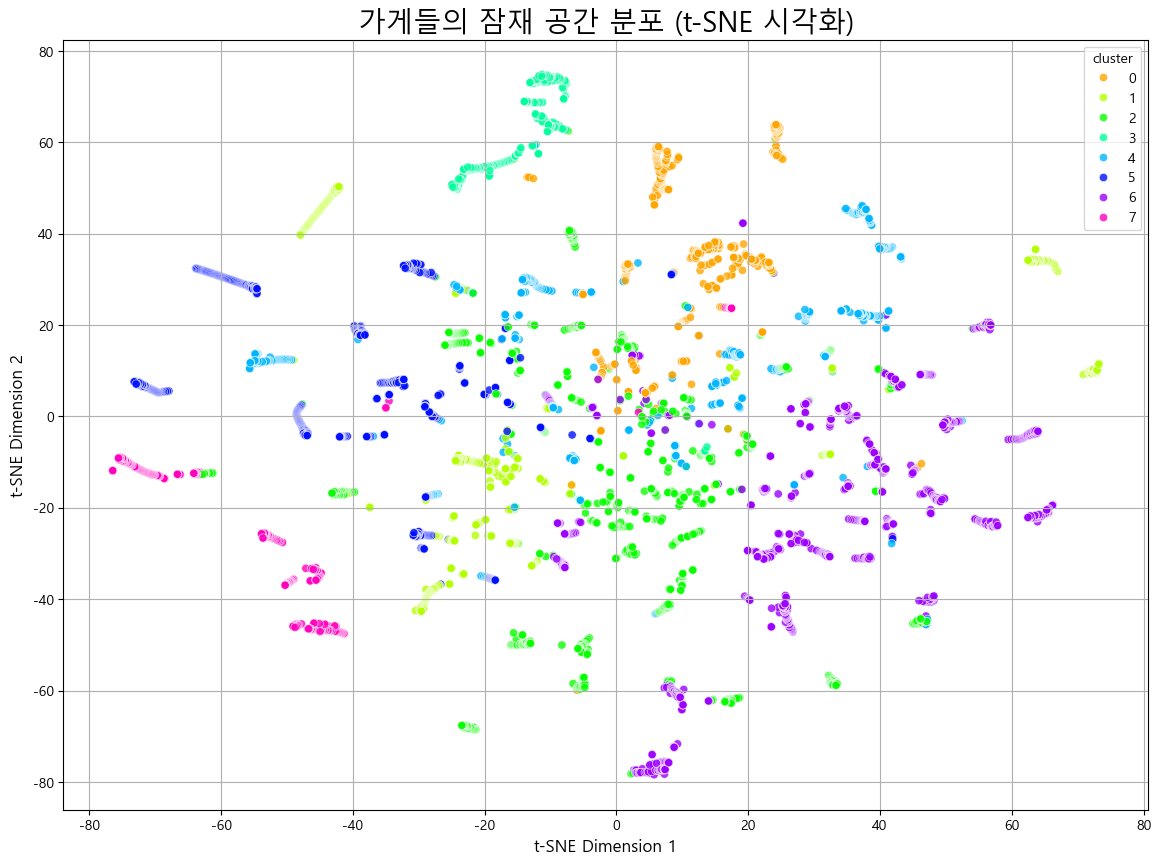


📊 (시각화 1) 잠재 공간 클러스터링 맵 출력 완료


In [8]:
# ==============================================================================
# 4. 잠재 공간 시각화
# ==============================================================================
plt.figure(figsize=(14, 10))
sns.scatterplot(
    x="tsne_1", y="tsne_2",
    hue="cluster", # 각 점의 색깔을 군집(cluster) 번호에 따라 다르게 표시
    palette=sns.color_palette("hsv", N_CLUSTERS),
    data=df_analysis,
    legend="full",
    alpha=0.8
)
plt.title('가게들의 잠재 공간 분포 (t-SNE 시각화)', fontsize=20)
plt.xlabel('t-SNE Dimension 1', fontsize=12)
plt.ylabel('t-SNE Dimension 2', fontsize=12)
plt.grid(True)
plt.show()

print("\n📊 (시각화 1) 잠재 공간 클러스터링 맵 출력 완료")

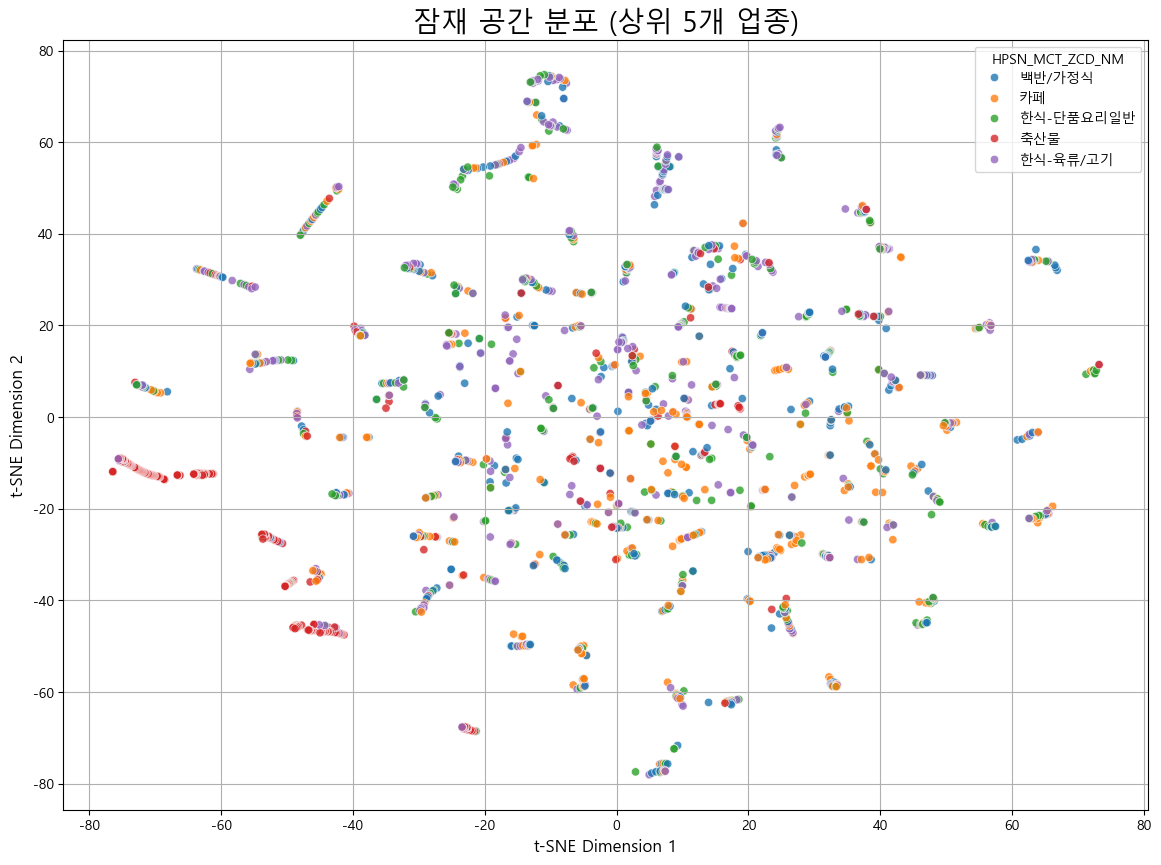

📊 (시각화 2) 업종별 잠재 공간 분포 맵 출력 완료


In [9]:
# 시각화 2: 상위 5개 업종을 기준으로 색칠해보기
top_5_categories = df_analysis['HPSN_MCT_ZCD_NM'].value_counts().nlargest(5).index
df_top5 = df_analysis[df_analysis['HPSN_MCT_ZCD_NM'].isin(top_5_categories)]

plt.figure(figsize=(14, 10))
sns.scatterplot(
    x="tsne_1", y="tsne_2",
    hue="HPSN_MCT_ZCD_NM", # 이번에는 업종에 따라 색깔을 다르게 표시
    data=df_top5,
    alpha=0.8
)
plt.title('잠재 공간 분포 (상위 5개 업종)', fontsize=20)
plt.xlabel('t-SNE Dimension 1', fontsize=12)
plt.ylabel('t-SNE Dimension 2', fontsize=12)
plt.grid(True)
plt.show()

print("📊 (시각화 2) 업종별 잠재 공간 분포 맵 출력 완료")